# DBLP Citation Impact Prediction

**Team Member:** Julio Amaya  
**Task:** Predictive Modeling  
**Date:** December 4, 2025

## Overview

This notebook builds predictive models to forecast citation impact of research papers:

1. Load paper data with features (metadata + topics)
2. Engineer features for prediction
3. Time-split data (pre-2010 train, post-2010 test)
4. Train classifiers (Logistic Regression, XGBoost, Random Forest)
5. Predict citation impact categories
6. Evaluate models (F1, AUC, accuracy)
7. Extract feature importance
8. Analyze high/low impact papers

---

In [1]:
# Import libraries
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import xgboost as xgb

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Create output directories
FIGURES_DIR = Path("../figures")
MODELS_DIR = Path("../models")
RESULTS_DIR = Path("../results")
FIGURES_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

print("✓ Libraries imported successfully")
print(f"Figures: {FIGURES_DIR.absolute()}")
print(f"Models: {MODELS_DIR.absolute()}")
print(f"Results: {RESULTS_DIR.absolute()}")

✓ Libraries imported successfully
Figures: /Users/julio/Library/CloudStorage/OneDrive-UniversityOfHouston/0. Fall 2025/COSC3337/GitProject/COSC-3337-Project/notebooks/../figures
Models: /Users/julio/Library/CloudStorage/OneDrive-UniversityOfHouston/0. Fall 2025/COSC3337/GitProject/COSC-3337-Project/notebooks/../models
Results: /Users/julio/Library/CloudStorage/OneDrive-UniversityOfHouston/0. Fall 2025/COSC3337/GitProject/COSC-3337-Project/notebooks/../results


In [2]:
# Load papers data
DATA_DIR = Path("../data/parquet")
papers = pd.read_parquet(DATA_DIR / 'papers')

# Load topic assignments from topic modeling
paper_topics = pd.read_csv(MODELS_DIR / 'paper_topics.csv')

# Merge papers with topics
df = papers.merge(paper_topics[['id', 'topic']], on='id', how='left')

print(f"Total papers: {len(df):,}")
print(f"Papers with topics: {df['topic'].notna().sum():,}")
print(f"\nDataset info:")
print(df.info())
print(f"\nSample data:")
print(df.head())

Total papers: 100,000
Papers with topics: 39,476

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100000 non-null  object 
 1   title         100000 non-null  object 
 2   venue         100000 non-null  object 
 3   year          100000 non-null  int64  
 4   n_citation    100000 non-null  int64  
 5   abstract      39476 non-null   object 
 6   abstract_len  39476 non-null   float64
 7   ref_count     100000 non-null  int64  
 8   author_count  100000 non-null  int64  
 9   topic         39476 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB
None

Sample data:
                                     id  \
0  00127ee2-cb05-48ce-bc49-9de556b93346   
1  001c58d3-26ad-46b3-ab3a-c1e557d16821   
2  001c8744-73c4-4b04-9364-22d31a10dbf1   
3  00338203-9eb3-40c5-9f31-cbac73a519ec   
4 

In [3]:
# Filter papers with required features
df_features = df[
    (df['year'].notna()) & 
    (df['n_citation'].notna()) &
    (df['topic'].notna())
].copy()

print(f"Papers with complete features: {len(df_features):,}")

# Create citation impact categories (low, medium, high)
# Using quantiles for balanced classes
citation_quantiles = df_features['n_citation'].quantile([0.33, 0.67])
print(f"\nCitation quantiles: {citation_quantiles.values}")

def categorize_citations(n_cit):
    if n_cit <= citation_quantiles.iloc[0]:
        return 0  # Low
    elif n_cit <= citation_quantiles.iloc[1]:
        return 1  # Medium
    else:
        return 2  # High

df_features['citation_impact'] = df_features['n_citation'].apply(categorize_citations)

# Paper age (newer papers have less time to accumulate citations)
df_features['paper_age'] = 2017 - df_features['year']

print(f"\nCitation impact distribution:")
print(df_features['citation_impact'].value_counts().sort_index())
print(f"\nFeature summary:")
print(df_features[['year', 'paper_age', 'author_count', 'ref_count', 'topic', 'n_citation', 'citation_impact']].describe())

Papers with complete features: 39,476

Citation quantiles: [ 2. 50.]

Citation impact distribution:
citation_impact
0    13697
1    23660
2     2119
Name: count, dtype: int64

Feature summary:
               year     paper_age  author_count     ref_count         topic  \
count  39476.000000  39476.000000  39476.000000  39476.000000  39476.000000   
mean    2008.273913      8.726087      3.003369      8.202807      9.595526   
std        6.633168      6.633168      1.620831      8.527912      2.874248   
min     1961.000000      0.000000      1.000000      0.000000      0.000000   
25%     2006.000000      5.000000      2.000000      2.000000      8.000000   
50%     2011.000000      6.000000      3.000000      6.000000     10.000000   
75%     2012.000000     11.000000      4.000000     12.000000     12.000000   
max     2017.000000     56.000000     61.000000    215.000000     14.000000   

         n_citation  citation_impact  
count  39476.000000     39476.000000  
mean      25.5505

In [4]:
# Encode venue (top venues + 'other' for rare ones)
top_venues = df_features['venue'].value_counts().head(50).index
df_features['venue_encoded'] = df_features['venue'].apply(
    lambda x: x if x in top_venues else 'OTHER'
)

# One-hot encode venue
venue_dummies = pd.get_dummies(df_features['venue_encoded'], prefix='venue')

# Select features for modeling
feature_cols = ['year', 'paper_age', 'author_count', 'ref_count', 'topic']
X_base = df_features[feature_cols].copy()

# Add venue features
X = pd.concat([X_base, venue_dummies], axis=1)
y = df_features['citation_impact']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeature columns: {X.columns.tolist()[:10]}... ({len(X.columns)} total)")

Feature matrix shape: (39476, 56)
Target distribution: {1: 23660, 0: 13697, 2: 2119}

Feature columns: ['year', 'paper_age', 'author_count', 'ref_count', 'topic', 'venue_', 'venue_Annales Des Télécommunications', 'venue_Annals of Operations Research', 'venue_Communications of The Ais', 'venue_Computing']... (56 total)


In [5]:
# Time-based split
SPLIT_YEAR = 2010

train_mask = df_features['year'] < SPLIT_YEAR
test_mask = df_features['year'] >= SPLIT_YEAR

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set (pre-{SPLIT_YEAR}): {len(X_train):,} papers")
print(f"Test set ({SPLIT_YEAR}+): {len(X_test):,} papers")
print(f"\nTrain class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest class distribution:")
print(y_test.value_counts().sort_index())

# Scale numerical features
scaler = StandardScaler()
numeric_cols = ['year', 'paper_age', 'author_count', 'ref_count']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"\n✓ Features scaled")

Training set (pre-2010): 15,345 papers
Test set (2010+): 24,131 papers

Train class distribution:
citation_impact
0    4381
1    9419
2    1545
Name: count, dtype: int64

Test class distribution:
citation_impact
0     9316
1    14241
2      574
Name: count, dtype: int64

✓ Features scaled


In [6]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1, eval_metric='mlogloss')
}

# Train and store results
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Multi-class AUC (one-vs-rest)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    
    accuracy = (y_pred == y_test).mean()
    
    results[name] = {
        'f1_score': f1,
        'auc': auc,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"  F1 Score: {f1:.4f}")
    print(f"  AUC: {auc:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

print("\n✓ All models trained")


Training Logistic Regression...
  F1 Score: 0.5598
  AUC: 0.6585
  Accuracy: 0.6259

Training Random Forest...
  F1 Score: 0.5598
  AUC: 0.6585
  Accuracy: 0.6259

Training Random Forest...
  F1 Score: 0.4934
  AUC: 0.6446
  Accuracy: 0.6077

Training XGBoost...
  F1 Score: 0.4934
  AUC: 0.6446
  Accuracy: 0.6077

Training XGBoost...
  F1 Score: 0.5692
  AUC: 0.6301
  Accuracy: 0.6208

✓ All models trained
  F1 Score: 0.5692
  AUC: 0.6301
  Accuracy: 0.6208

✓ All models trained


Model Performance Comparison:
              Model  F1 Score      AUC  Accuracy
Logistic Regression  0.559811 0.658454  0.625875
      Random Forest  0.493431 0.644636  0.607725
            XGBoost  0.569221 0.630107  0.620820

✓ Results saved to ../results


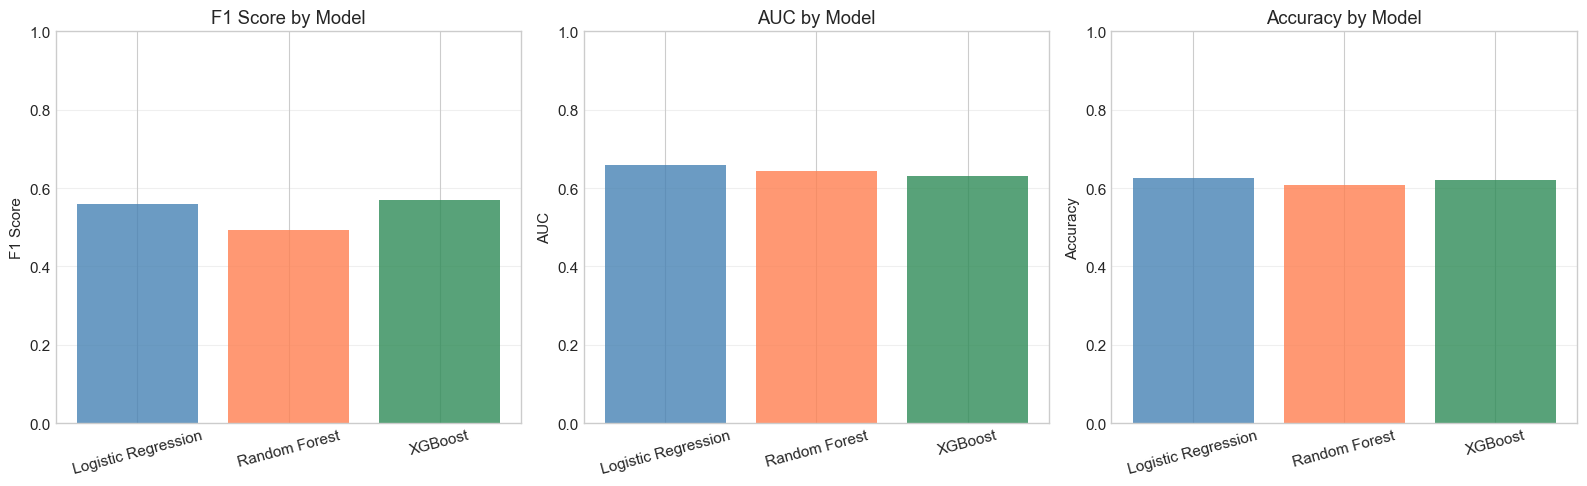

✓ Figure saved to ../figures


In [7]:
# Model comparison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'F1 Score': [results[m]['f1_score'] for m in results.keys()],
    'AUC': [results[m]['auc'] for m in results.keys()],
    'Accuracy': [results[m]['accuracy'] for m in results.keys()]
})

print("Model Performance Comparison:")
print("="*60)
print(comparison_df.to_string(index=False))

# Save results
comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Results saved to {RESULTS_DIR}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, metric in enumerate(['F1 Score', 'AUC', 'Accuracy']):
    axes[i].bar(comparison_df['Model'], comparison_df[metric], color=['steelblue', 'coral', 'seagreen'], alpha=0.8)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} by Model')
    axes[i].set_ylim([0, 1])
    axes[i].grid(axis='y', alpha=0.3)
    axes[i].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig7_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to {FIGURES_DIR}")

Top 15 Most Important Features:
                                                               feature  importance
                                                             ref_count    0.351370
                                                                  year    0.117070
                                                                 topic    0.113978
                                                             paper_age    0.112646
                                                          author_count    0.100918
                                                                venue_    0.036080
              venue_international conference on computers in education    0.035079
       venue_international joint conference on artificial intelligence    0.032284
                      venue_Journal of Machine Vision and Applications    0.021413
                  venue_national conference on artificial intelligence    0.016665
venue_conference of the international speech communicat

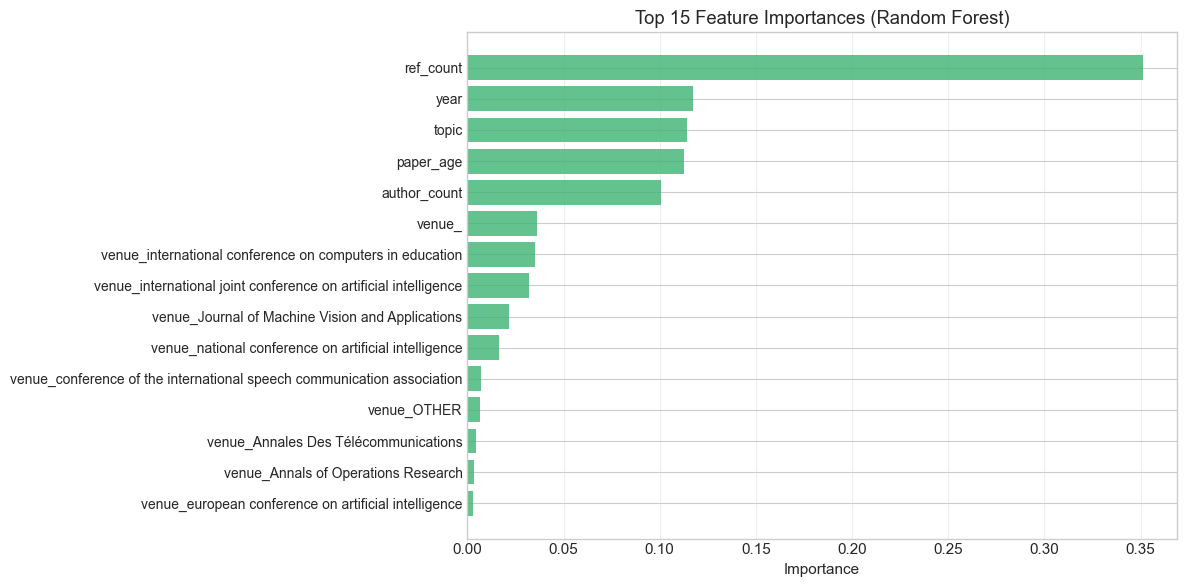


✓ Feature importance saved to ../results


In [8]:
# Get feature importance from Random Forest (best tree-based model)
rf_model = trained_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 features
top_features = feature_importance.head(15)

print("Top 15 Most Important Features:")
print("="*60)
print(top_features.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(top_features)), top_features['importance'], color='mediumseagreen', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=10)
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances (Random Forest)')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig8_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
feature_importance.to_csv(RESULTS_DIR / 'feature_importance.csv', index=False)
print(f"\n✓ Feature importance saved to {RESULTS_DIR}")

In [9]:
# Add predictions to test data
df_test = df_features[test_mask].copy()
df_test['predicted_impact'] = results['Random Forest']['predictions']

# High impact papers (correctly predicted)
high_impact_correct = df_test[
    (df_test['citation_impact'] == 2) & 
    (df_test['predicted_impact'] == 2)
].nlargest(5, 'n_citation')

print("High Impact Papers (Correctly Predicted):")
print("="*80)
print(high_impact_correct[['title', 'year', 'venue', 'n_citation', 'author_count', 'topic']].to_string())

# Low impact papers (correctly predicted)
low_impact_correct = df_test[
    (df_test['citation_impact'] == 0) & 
    (df_test['predicted_impact'] == 0)
].head(5)

print("\n\nLow Impact Papers (Correctly Predicted):")
print("="*80)
print(low_impact_correct[['title', 'year', 'venue', 'n_citation', 'author_count', 'topic']].to_string())

# Save case studies
high_impact_correct.to_csv(RESULTS_DIR / 'high_impact_cases.csv', index=False)
low_impact_correct.to_csv(RESULTS_DIR / 'low_impact_cases.csv', index=False)

print(f"\n✓ Case studies saved to {RESULTS_DIR}")

High Impact Papers (Correctly Predicted):
Empty DataFrame
Columns: [title, year, venue, n_citation, author_count, topic]
Index: []


Low Impact Papers (Correctly Predicted):
                                                                                                                      title  year venue  n_citation  author_count  topic
173  Soft Systems Methodology for Hard Systems Engineering - The Case of Information Systems Development at LIT/INPE/BRAZIL  2013                 0             2   10.0
195                                                                           Teaching and Learning in Technical IT Courses  2014                 0             1   10.0
778                Découverte et analyse des communautés implicites par une approche sémantique en ligne : l'outil WebTribe  2012                 0             1    3.0
887               A Mixed Methods Approach for Measuring the Impact of Delivery-Centric Interventions on Clinician Workflow  2012                 0   

In [10]:
# Save best model
import joblib

best_model_name = comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

joblib.dump(best_model, MODELS_DIR / 'citation_predictor.pkl')
joblib.dump(scaler, MODELS_DIR / 'feature_scaler.pkl')

print(f"✓ Best model ({best_model_name}) saved to {MODELS_DIR}")

# Final summary
print("\n" + "="*80)
print("PREDICTIVE MODELING SUMMARY")
print("="*80)
print(f"Task: Citation Impact Prediction (3 classes)")
print(f"Train: Pre-{SPLIT_YEAR} ({len(X_train):,} papers)")
print(f"Test: {SPLIT_YEAR}+ ({len(X_test):,} papers)")
print(f"Features: {X.shape[1]} (metadata + topics + venues)")
print(f"\nBest Model: {best_model_name}")
print(f"  F1 Score: {comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'F1 Score']:.4f}")
print(f"  AUC: {comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'AUC']:.4f}")
print(f"  Accuracy: {comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Accuracy']:.4f}")
print(f"\nTop 3 Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")
print(f"\nFiles generated:")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Results: {RESULTS_DIR}")
print(f"  - Figures: {FIGURES_DIR}")
print("="*80)

✓ Best model (XGBoost) saved to ../models

PREDICTIVE MODELING SUMMARY
Task: Citation Impact Prediction (3 classes)
Train: Pre-2010 (15,345 papers)
Test: 2010+ (24,131 papers)
Features: 56 (metadata + topics + venues)

Best Model: XGBoost
  F1 Score: 0.5692
  AUC: 0.6301
  Accuracy: 0.6208

Top 3 Important Features:
  ref_count: 0.3514
  year: 0.1171
  topic: 0.1140

Files generated:
  - Models: ../models
  - Results: ../results
  - Figures: ../figures


## 8. Summary

Export models and final summary.

## 7. Case Studies

Analyze examples of high and low impact papers.

## 6. Feature Importance

Analyze which features are most important for prediction.

## 5. Model Evaluation

Compare model performance and visualize results.

## 4. Train Models

Train Logistic Regression, Random Forest, and XGBoost classifiers.

## 3. Time-Based Train/Test Split

Split data temporally: pre-2010 for training, post-2010 for testing.

## 2. Feature Engineering

Create features for prediction and define target variable (citation impact).

## 1. Load Data